In [264]:
import numpy as np
from scipy.special import softmax
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [346]:
class FairRegressionDiscret():
    def __init__(self, base_method, beta=1, L=20, num_iter=1000, M=10, weights=[.5, .5]):
        self.base_method = base_method
        self.beta = beta
        self.L = L
        self.num_iter = num_iter
        self.M = M
        self.weights = weights
    def fit(self, X_unlab):
        coef = np.zeros(2 * self.L + 1)
        moment = np.zeros(2 * self.L + 1)
        y_pred0 = self.base_method.predict(X_unlab[X_unlab[:,-1] == -1])
        y_pred1 = self.base_method.predict(X_unlab[X_unlab[:,-1] == 1])
        discr = np.arange(-self.L, self.L + 1) * self.M / self.L
        z0 = self.weights[0] * np.square(y_pred0[:, np.newaxis] - discr)
        z1 = self.weights[1] * np.square(y_pred1[:, np.newaxis] - discr)
        tau = 0
        for t in range(self.num_iter):
            tmp = (1 + np.sqrt(1 + 4 * tau ** 2)) / 2
            gamma = (1 - tau) / tmp
            tau = tmp
            coef_prev = coef
            coef = moment - (self.beta / 2) *  (np.mean(softmax((moment - z1) / self.beta, axis=1), axis=0) - np.mean(softmax((-moment - z0) / self.beta, axis=1), axis=0))
            moment = (1 - gamma) * coef + gamma * coef_prev
        self.coef_ = coef
    def predict(self, X):
        n_samples, _ = X.shape
        s = np.zeros(n_samples)
        discr = np.arange(-self.L, self.L + 1) * self.M / self.L
        s[X[:,-1] == -1] = -1
        s[X[:,-1] == 1] = 1
        y_pred = self.base_method.predict(X)
        z =  np.square(y_pred[:, np.newaxis] - discr)
        z[X[:,-1] == -1, :] *= self.weights[0]
        z[X[:,-1] == 1, :] *= self.weights[1]
        return (np.argmin(-s[:,np.newaxis] * self.coef_ + z, axis=1) - self.L) * self.M / self.L

In [363]:
N_train = 500
thr = 0

X_train = np.random.normal(0, 1, (N_train, 3))
sens = np.zeros(N_train)
sens[X_train[:, 0] < thr] = -1
sens[X_train[:, 0] >= thr] = 1
sens = sens[:, np.newaxis]
X_train = np.append(X_train, sens, axis=1)
y_train = np.dot(X_train, np.ones(4) * 3) + np.random.normal(0, 1, N_train)


N_unlab = 1000
X_unlab = np.random.normal(0, 1, (N_unlab, 3))
sens = np.zeros(N_unlab)
sens[X_unlab[:, 0] < thr] = -1
sens[X_unlab[:, 0] >= thr] = 1
sens = sens[:, np.newaxis]
X_unlab = np.append(X_unlab, sens, axis=1)

In [392]:
ls = LinearRegression(fit_intercept=False)
ls.fit(X_train, y_train)
weights = [.5, .5]
fair_ls =  FairRegressionDiscret(ls, M=20, weights=weights, L=100, num_iter=20000, beta=1)
fair_ls.fit(X_unlab)

In [393]:
y_pred = fair_ls.predict(X_unlab)
# print(y_pred.shape)

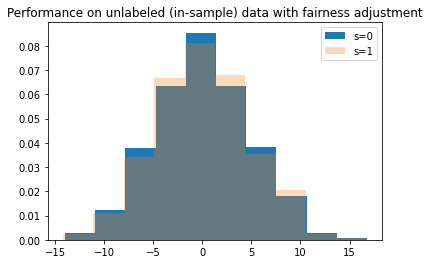

In [394]:
y_pred0 = y_pred[X_unlab[:, -1] == -1]
y_pred1 = y_pred[X_unlab[:, -1] == 1]

plt.figure('1')
plt.hist(y_pred0, label='s=0', density=True, stacked=True)
plt.hist(y_pred1, label='s=1', alpha=0.3, density=True, stacked=True)
plt.title('Performance on unlabeled (in-sample) data with fairness adjustment')
plt.legend()

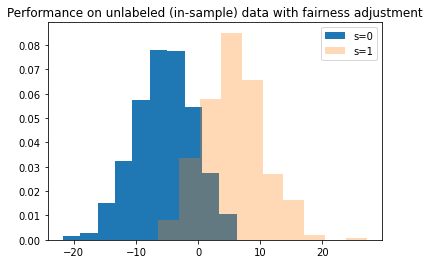

In [395]:
y_pred = ls.predict(X_unlab)
y_pred0 = y_pred[X_unlab[:, -1] == -1]
y_pred1 = y_pred[X_unlab[:, -1] == 1]

plt.figure('1')
plt.hist(y_pred0, label='s=0', density=True, stacked=True)
plt.hist(y_pred1, label='s=1', alpha=0.3, density=True, stacked=True)
plt.title('Performance on unlabeled (in-sample) data with fairness adjustment')
plt.legend()